In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras

import pandas as pd
import numpy as np

from collections import Counter
import pycountry_convert as pc

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from copy import deepcopy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from tensorflow.keras.optimizers import Adam


import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Preprocessing 

In [2]:
df = pd.read_csv('preprocessed_imdb.csv')
df = df.dropna()

### Countries Feature

For dealing with countries feature we one hot them by their continent.  

In [3]:
def country_to_continent(country_name):
    if country_name == 'United States':
        country_name = "United States of America"

    if country_name == 'West Germany':
        country_name = "Germany"

    if country_name == 'Netherlands Antilles':
        country_name = "Venezuela"
    
    if country_name == 'Soviet Union':
        country_name = "Russia"
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    
    except LookupError:
        print(f"Country: {country_name} Not found")
        return "Not found"

In [4]:
df['Country_list'] = df['Country of Origin'].str.split('~')
df['Continents'] = df['Country_list'].apply(lambda countries: [country_to_continent(country) for country in countries])


all_continents = set(continent for sublist in df['Continents'] for continent in sublist)
for continent in all_continents:
    df[continent] = df['Continents'].apply(lambda x: int(continent in x))


df.drop(df[df['Not found'] == 1].index, inplace=True)
df = df.drop(columns=['Continents', 'Not found'])


df.describe()

Country: Serbia and Montenegro Not found
Country: Federal Republic of Yugoslavia Not found
Country: Yugoslavia Not found


c:\Users\behra\anaconda3\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\behra\anaconda3\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit,Asia,North America,Africa,Oceania,Europe,South America
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,41.279362,128.291388,87.012026,0.122669,0.913983,0.008686,0.047034,0.342797,0.005720
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,47.459251,209.485580,178.956505,0.328092,0.280419,0.092805,0.211734,0.474694,0.075424
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.059963,0.883066,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,25.000000,55.418696,28.148098,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.969526,97.493462,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Genere one hot encoding

In [5]:
df['Genre_list'] = df['Genre'].str.split('~')

all_genres = set(genre for sublist in df['Genre_list'] for genre in sublist)
print("total number of generes: ", len(all_genres))

for genre in all_genres:
    df[genre] = df['Genre_list'].apply(lambda x: int(genre in x))

df = df.drop(columns=['Genre_list'])

total number of generes:  22


In [6]:
genre_sums = df[list(all_genres)].sum()
genres_to_drop = genre_sums[genre_sums < 200].index
df.drop(columns=genres_to_drop, inplace=True)

In [7]:
genres_to_drop

Index(['Sport', 'Documentary', 'History', 'Western', 'War', 'Film-Noir',
       'Musical', 'Music'],
      dtype='object')

### companies

In [8]:
all_companies = df['Companies'].str.split('~').explode()
company_counts = Counter(all_companies)
top_companies = company_counts.most_common(25)
top_df = pd.DataFrame(top_companies, columns=['Company', 'Frequency'])
print(top_df)
print(top_df['Frequency'].sum() / df.shape[0])

                      Company  Frequency
0                Warner Bros.        372
1          Universal Pictures        362
2           Columbia Pictures        315
3          Paramount Pictures        309
4       Twentieth Century Fox        220
5        Walt Disney Pictures        176
6             New Line Cinema        171
7   Metro-Goldwyn-Mayer (MGM)        112
8            Relativity Media        110
9         Dreamworks Pictures        107
10    New Regency Productions        105
11        Touchstone Pictures        105
12            Lionsgate Films         87
13  Village Roadshow Pictures         84
14                    Miramax         72
15       Summit Entertainment         70
16       Amblin Entertainment         59
17                StudioCanal         56
18                Screen Gems         55
19          Fox 2000 Pictures         54
20             Focus Features         54
21    Legendary Entertainment         53
22           TriStar Pictures         53
23      Imagine 

In [9]:
df.describe()

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit,Asia,North America,...,Thriller,Romance,Horror,Fantasy,Animation,Action,Biography,Crime,Drama,Family
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,...,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,41.279362,128.291388,87.012026,0.122669,0.913983,...,0.176059,0.144703,0.127119,0.091737,0.057415,0.306780,0.073729,0.200847,0.493432,0.055932
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,47.459251,209.485580,178.956505,0.328092,0.280419,...,0.380911,0.351839,0.333141,0.288685,0.232659,0.461206,0.261357,0.400677,0.500010,0.229815
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.059963,0.883066,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,25.000000,55.418696,28.148098,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.969526,97.493462,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Age Restriction

In [10]:
age_restriction_counts = df['Age Restriction'].value_counts()


valid_age_restrictions = age_restriction_counts[age_restriction_counts >= 200].index

df = df[df['Age Restriction'].isin(valid_age_restrictions)]


df = pd.concat([df, pd.get_dummies(df['Age Restriction'], prefix='Age_Restriction', dtype=int)], axis=1)
columns_to_drop = ['Age Restriction', 'Title']
df.drop(columns_to_drop, axis=1, inplace=True)

print(df.head())


   Release Year  Duration                    Genre  Rating  Number of Votes  \
0          1994       142                    Drama     9.3          2900000   
1          2008       152       Action~Crime~Drama     9.0          2900000   
2          2010       148  Action~Adventure~Sci-Fi     8.8          2500000   
3          1999       139                    Drama     8.8          2300000   
4          1994       142            Drama~Romance     8.8          2300000   

   Meta Score                 Language             Country of Origin  \
0          82                  English                 United States   
1          84         English~Mandarin  United States~United Kingdom   
2          74  English~Japanese~French  United States~United Kingdom   
3          67                  English         Germany~United States   
4          82                  English                 United States   

                                           Companies  Budget  ...  Fantasy  \
0             

In [11]:
columns_to_drop = ['Country_list', 'Genre', 'Country of Origin', 'Companies','Language']
df.drop(columns_to_drop, axis=1, inplace=True)

## Feature Engineering

### Feature Scaling

In [12]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

exclude_columns = ['Europe', 'Asia', 'Oceania', 'Africa', 'South America', 'North America',
                   'Romance', 'Fantasy', 'Animation', 'Crime', 'Drama', 'Adventure',
                   'Family', 'Comedy', 'Sci-Fi', 'Horror', 'Thriller', 'Biography',
                   'Mystery', 'Action', 'Age_Restriction_PG', 'Age_Restriction_PG-13',
                   'Age_Restriction_R']

columns_to_scale = [col for col in df.columns if col not in exclude_columns]

min_max_scaler.fit(df)
df[df.columns] = min_max_scaler.transform(df)

standard_scaler.fit(df[columns_to_scale])
df[columns_to_scale] = standard_scaler.transform(df[columns_to_scale])

## Dimensionality Reduction

In [13]:
features = df.drop(columns=['profit', 'Rating'])
targets = df[['profit', 'Rating']]

### Use the PCA method to reduce the dimensions of numerical features to two dimensions

In [14]:
numerical_features = features.select_dtypes(include=[np.number])
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numerical_features)



### How much of the initial data variance is transferred to the new space?

In [15]:
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
variance_ratio = pca.explained_variance_ratio_
transferred_variance = variance_ratio.sum()
print(f"Transferred variance to 2D space: {transferred_variance * 100:.2f}%")

Transferred variance to 2D space: 44.91%


### If we aim to retain 95% of the original variance, what is the minimum number of dimensions required in the new space?

In [16]:
pca_95 = PCA(0.95)
pca_95.fit(numerical_features)
n_components_95 = pca_95.n_components_
print(f"Number of components to retain 95% variance: {n_components_95}")

df.to_csv('preprocessed_original.csv', index=False)
reduced_df_with_targets = pd.concat([reduced_df, targets.reset_index(drop=True)], axis=1)
reduced_df_with_targets.to_csv('reduced_data.csv', index=False)

Number of components to retain 95% variance: 18


# Part 5: Model Training

## EDA for Enhancing Machine Learning Models

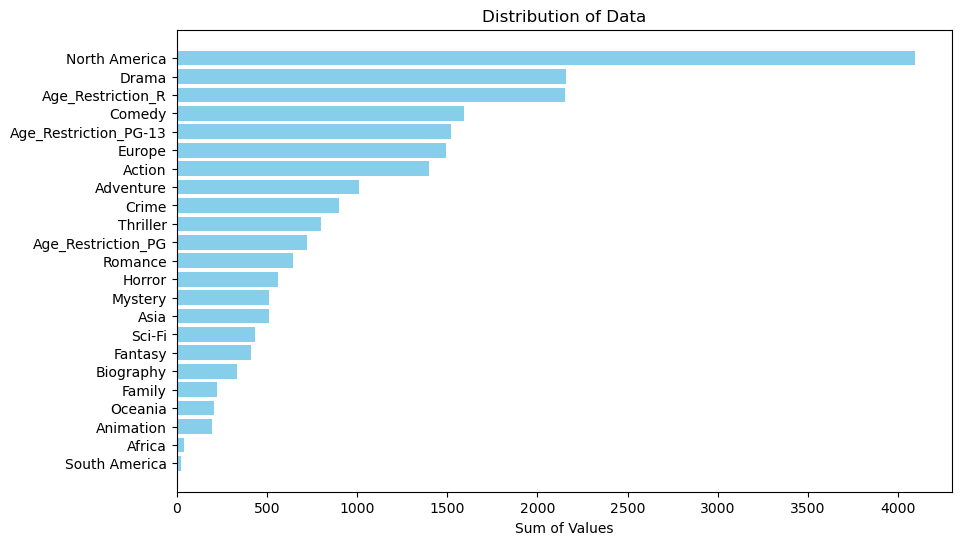

In [17]:
def calculate_column_sum(data, columns):
    column_sums = {}
    for column in columns:
        column_sums[column] = data[column].sum()
    return column_sums

specified_columns = ['North America', 'Africa', 'Asia', 'Europe', 'Oceania', 'South America', 
                     'Horror', 'Comedy', 'Fantasy', 'Drama', 'Family', 'Animation', 
                     'Biography', 'Adventure', 'Mystery', 'Action', 'Crime', 'Sci-Fi', 
                     'Thriller', 'Romance', 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']

column_sums = calculate_column_sum(df, specified_columns)

sorted_column_sums = dict(sorted(column_sums.items(), key=lambda item: item[1]))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_column_sums.keys()), list(sorted_column_sums.values()), color='skyblue')
plt.xlabel('Sum of Values')
plt.title('Distribution of Data')
plt.show()

## Regression : 

In [21]:
class RatingNN(nn.Module):
    def __init__(self, input_size):
        super(RatingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class GrossNN(nn.Module):
    def __init__(self, input_size):
        super(GrossNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
def run_experiment(file_path, model_name, epochs, early_stopping=None, apply_PCA= False, scaling=True, **kwargs):
    # Load and prepare data
    data = pd.read_csv(file_path)
    data = data.select_dtypes(include=[np.number])
    
    # Split and standardize data
    target_column = kwargs.get('target_column')
    drop_columns = kwargs.get('drop_columns', [])
    X = data.drop(drop_columns, axis=1)
    y = data[target_column]

    if(scaling):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    if(apply_PCA == True):
        pca_95 = PCA(0.95)
        X_pca = pca_95.fit_transform(X)
        n_components_95 = pca_95.n_components_
        print(f"Number of components to retain 95% variance: {n_components_95}")
        X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components_95)])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)
    
    scaler = StandardScaler()
    
    # Train model
    if model_name.lower() == 'mlpregressor':
        model = MLPRegressor(**kwargs.get('model_params', {}))
        model.fit(X_train, y_train)
        



    if(model_name.lower() == 'ratingnn' or model_name.lower() == 'grossnn'):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Convert DataFrame to NumPy array if needed
        X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
        y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
        
        train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32), 
                                    torch.tensor(y_train_np, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        if(model_name.lower() == 'ratingnn'):
            model = RatingNN(X_train.shape[1]).to(device)
        else:
            model = GrossNN(X_train.shape[1]).to(device)

        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), **kwargs.get('optimizer_params', {}))
        
        best_loss = float('inf')
        epochs_no_improve = 0
        early_stopping_patience = early_stopping or 10
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
            
            train_loss /= len(train_loader.dataset)


            model.eval()
            with torch.no_grad():
                # Convert DataFrame to NumPy array
                X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
                y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test
                
                inputs, targets = torch.tensor(X_test_np, dtype=torch.float32).to(device), \
                                torch.tensor(y_test_np, dtype=torch.float32).to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, targets.unsqueeze(1)).item()
            

            if val_loss < best_loss:
                best_loss = val_loss
                epochs_no_improve = 0
                best_model = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print('Early stopping')
                    break
        
        model.load_state_dict(best_model)
    
    # Evaluate model
    if model_name.lower() == 'mlpregressor':
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    elif model_name.lower() == 'ratingnn' or model_name.lower() == 'grossnn':
        model.eval()
        with torch.no_grad():
            # Convert DataFrame to NumPy array
            X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
            X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

            y_train_pred = model(torch.tensor(X_train_np, dtype=torch.float32).to(device)).cpu().numpy().flatten()
            y_test_pred = model(torch.tensor(X_test_np, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Print results
    task_name = kwargs.get('task_name', 'Experiment')
    print(f"{task_name} - Mean Squared Error (Train):", mse_train)
    print(f"{task_name} - Mean Squared Error (Test):", mse_test)
    print(f"{task_name} - R^2 Score (Train):", r2_train)
    print(f"{task_name} - R^2 Score (Test):", r2_test)
    
    # Plot predicted vs actual
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_test_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') 
    plt.title(f"{task_name} Prediction")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

### Predicting Gross Worldwide

#### Using the actual dataset

Gross Worldwide - Mean Squared Error (Train): 0.029090390424892528
Gross Worldwide - Mean Squared Error (Test): 0.2756511191336554
Gross Worldwide - R^2 Score (Train): 0.970436622809266
Gross Worldwide - R^2 Score (Test): 0.7406862937857647


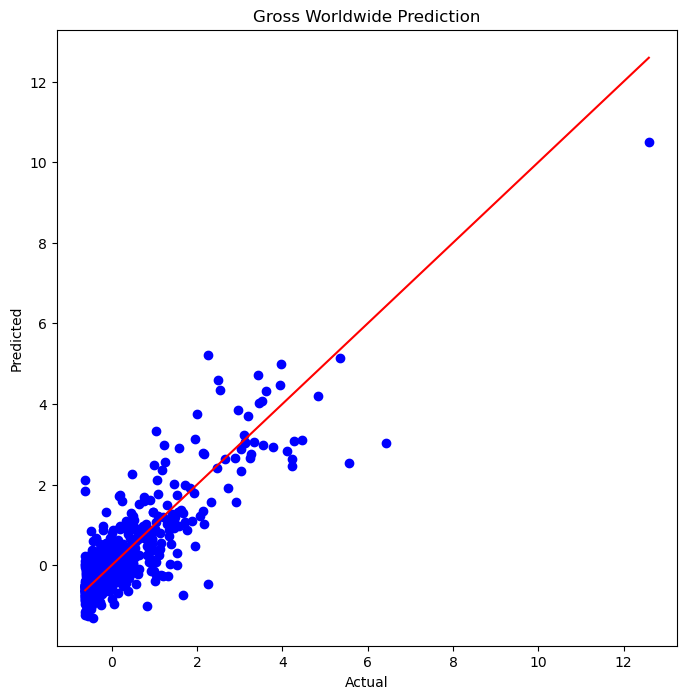

In [59]:
run_experiment('preprocessed_original.csv', 'mlpregressor', 500, target_column='Gross (worldwide)', drop_columns=['profit', 'Gross (worldwide)'], task_name='Gross Worldwide', model_params={'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500, 'random_state': 888})

#### Using the applied PCA dataset

Number of components to retain 95% variance: 23
Gross Worldwide - Mean Squared Error (Train): 0.0457567006580548
Gross Worldwide - Mean Squared Error (Test): 0.33350766515138186
Gross Worldwide - R^2 Score (Train): 0.9534993315387044
Gross Worldwide - R^2 Score (Test): 0.6862588152260402


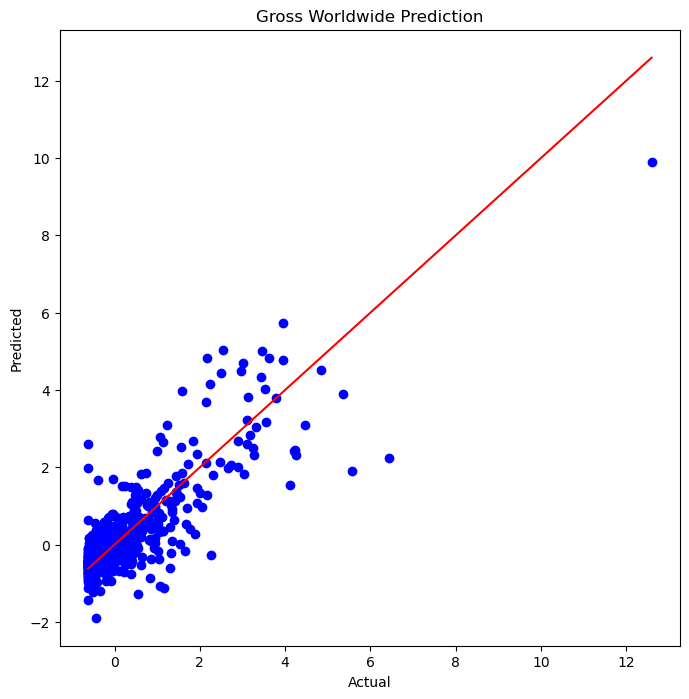

In [60]:
run_experiment('preprocessed_original.csv', 'mlpregressor', 500, target_column='Gross (worldwide)', drop_columns=['profit', 'Gross (worldwide)'], task_name='Gross Worldwide', apply_PCA=True,model_params={'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500, 'random_state': 888})

### Predicting Rating

#### Using the Actual Data

Early stopping
Rating Prediction - Mean Squared Error (Train): 0.007122453994935926
Rating Prediction - Mean Squared Error (Test): 0.0071220062890111945
Rating Prediction - R^2 Score (Train): 0.9929190563414932
Rating Prediction - R^2 Score (Test): 0.9927052983017711


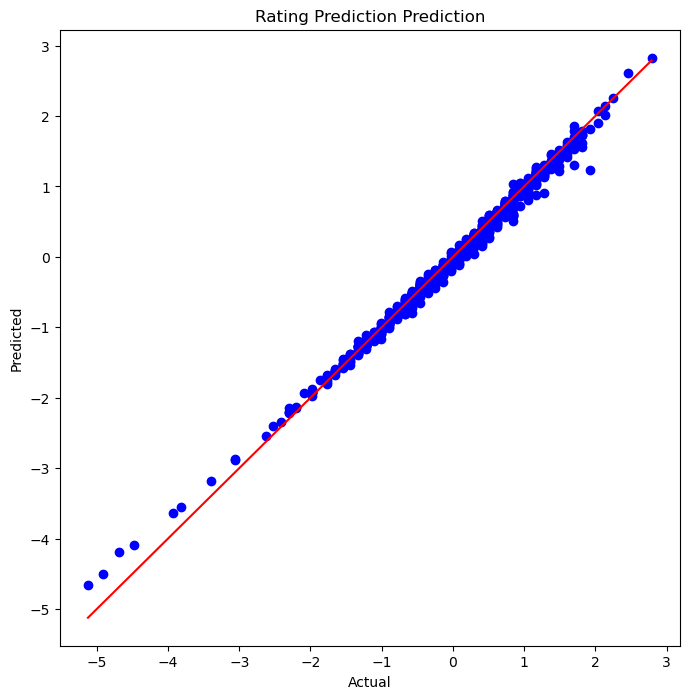

In [61]:
run_experiment(file_path='preprocessed_original.csv',model_name='ratingnn',epochs=100,early_stopping=10,target_column='Rating',drop_columns=['Meta Score'],
               task_name='Rating Prediction', optimizer_params={'lr': 0.001, 'weight_decay': 0.01} )


#### Using the applied PCA data

Number of components to retain 95% variance: 24
Early stopping
Rating Prediction - Mean Squared Error (Train): 0.032637368040265326
Rating Prediction - Mean Squared Error (Test): 0.03780908731284377
Rating Prediction - R^2 Score (Train): 0.9675528456316624
Rating Prediction - R^2 Score (Test): 0.9612741126253939


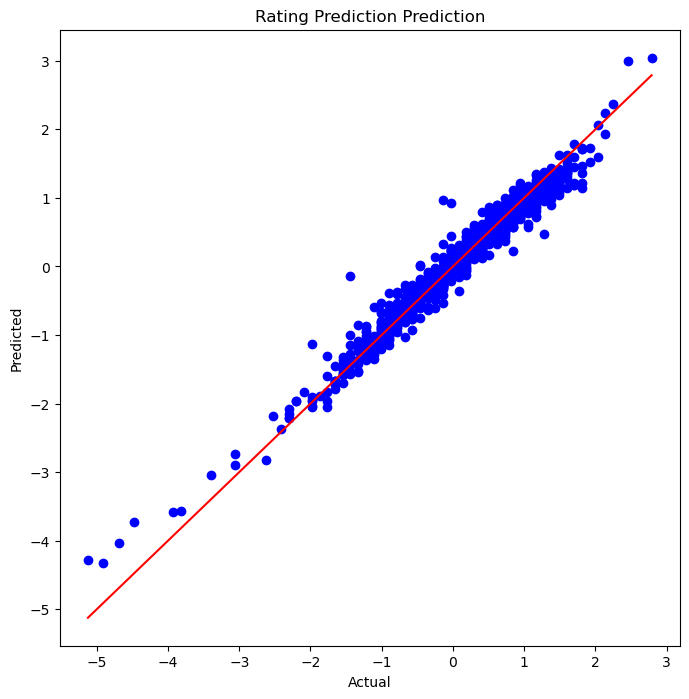

In [46]:
run_experiment(file_path='preprocessed_original.csv',model_name='ratingnn',epochs=100,early_stopping=10, apply_PCA=True,target_column='Rating',drop_columns=['Meta Score'],
               task_name='Rating Prediction', optimizer_params={'lr': 0.001, 'weight_decay': 0.01} )

PART 6

Training the models using the PCA-applied dataset, in this case, resulted in reducing the r^2 score by a little. This is because the new dataset had to undergo some information loss. Well, because when we try to reduce the number of features in a dataset, it would be impossible to keep every information in our dataset. 

In [4]:
class Evaluator:
    def __init__(self, models: dict, x_train, y_train, x_test, y_test):
        self.models = models
        self.x_test = x_test
        self.y_test = y_test
        self.x_train = x_train
        self.y_train = y_train
        self.predict = dict()
    
    def evaluate_models(self):
        for model in self.models.keys():
            print("Model: ", model)
            print(classification_report(self.y_test, self.predict[model], zero_division=0))
    
    def calculate_confusion_matrix(self):
        self.predict = {i: self.models[i].predict(self.x_test) for i in self.models.keys()}
        output = dict()
        for model in self.models.keys():
            if(isinstance(self.y_test, pd.DataFrame)):
                result = confusion_matrix(self.y_test.values.argmax(axis=1), self.predict[model].argmax(axis=1))
            else:
                result = confusion_matrix(self.y_test.values, self.predict[model])
            sns.heatmap(result, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix for Model {model}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
            output[model] = result
        return output
    
    def modify_model_list(self, model):
        for attr in model.keys():
            self.models[attr] = model[attr]
            
    def clear_previous_result(self):
        self.models.clear()
        self.predict.clear()
    
    def train_new_models(self, models):
        for name, model in models.items():
            self.modify_model_list({f'{name}':deepcopy(model).fit(self.x_train, self.y_train)})

In [5]:
data = pd.read_csv('preprocessed_original.csv')
data['Meta Score']

0       1.407775
1       1.520750
2       0.955874
3       0.560460
4       1.407775
          ...   
4395   -1.247145
4396   -1.134169
4397    0.729923
4398    0.786411
4399    0.052071
Name: Meta Score, Length: 4400, dtype: float64

Linear Regression:
  Train MSE: 0.4796, Test MSE: 0.5727
  Train R^2: 0.5108, Test R^2: 0.4688
Ridge Regression:
  Train MSE: 0.4796, Test MSE: 0.5727
  Train R^2: 0.5107, Test R^2: 0.4688
Lasso Regression:
  Train MSE: 0.9803, Test MSE: 1.0790
  Train R^2: 0.0000, Test R^2: -0.0009
Gradient Boosting Regressor:
  Train MSE: 0.2784, Test MSE: 0.4277
  Train R^2: 0.7160, Test R^2: 0.6032
XGBoosting Regressor:
  Train MSE: 0.0330, Test MSE: 0.4437
  Train R^2: 0.9663, Test R^2: 0.5884


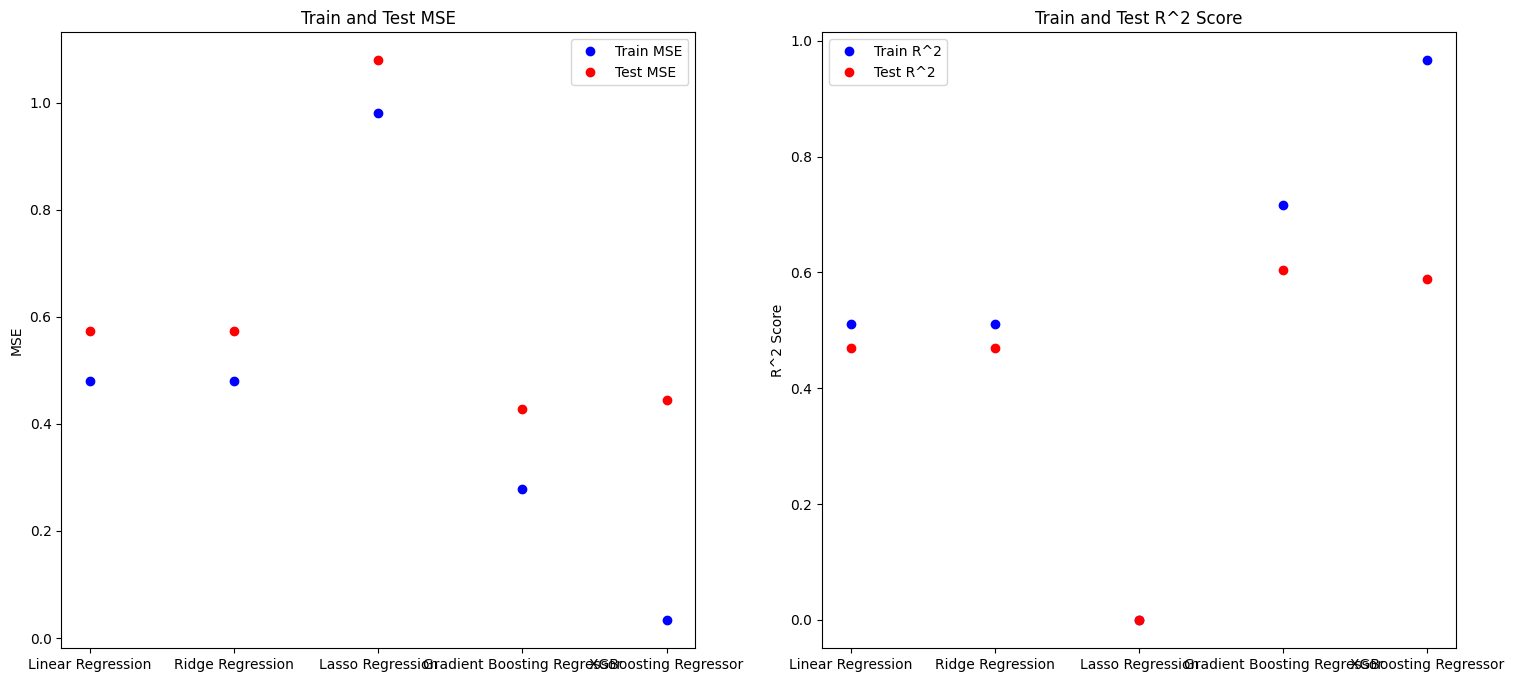

In [23]:
data = pd.read_csv('preprocessed_original.csv')
data = data.select_dtypes(include=[float, int])
rating_data = data.drop(['Meta Score'], axis=1)
X_rating = rating_data.drop('Rating', axis=1)
y_rating = rating_data['Rating']
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X_rating, y_rating, test_size=0.2, random_state=888)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'XGBoosting Regressor': XGBRegressor()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_rating, y_train_rating)
    y_train_pred = model.predict(X_train_rating)
    y_test_pred = model.predict(X_test_rating)
    
    train_mse = mean_squared_error(y_train_rating, y_train_pred)
    test_mse = mean_squared_error(y_test_rating, y_test_pred)
    train_r2 = r2_score(y_train_rating, y_train_pred)
    test_r2 = r2_score(y_test_rating, y_test_pred)
    
    results[model_name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R^2': train_r2,
        'Test R^2': test_r2
    }


for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Train MSE: {metrics['Train MSE']:.4f}, Test MSE: {metrics['Test MSE']:.4f}")
    print(f"  Train R^2: {metrics['Train R^2']:.4f}, Test R^2: {metrics['Test R^2']:.4f}")


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train MSE'], 'bo', label='Train MSE' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test MSE'], 'ro', label='Test MSE' if model_name == 'Linear Regression' else "")
plt.title('Train and Test MSE')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train R^2'], 'bo', label='Train R^2' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test R^2'], 'ro', label='Test R^2' if model_name == 'Linear Regression' else "")
plt.title('Train and Test R^2 Score')
plt.ylabel('R^2 Score')
plt.legend()

plt.show()


Linear Regression:
  Train MSE: 0.4870, Test MSE: 0.5483
  Train R^2: 0.5042, Test R^2: 0.4879
Ridge Regression:
  Train MSE: 0.4870, Test MSE: 0.5482
  Train R^2: 0.5042, Test R^2: 0.4880
Lasso Regression:
  Train MSE: 0.9823, Test MSE: 1.0710
  Train R^2: 0.0000, Test R^2: -0.0003
Gradient Boosting Regressor:
  Train MSE: 0.1676, Test MSE: 0.3624
  Train R^2: 0.8294, Test R^2: 0.6615
XGBoosting Regressor:
  Train MSE: 0.0121, Test MSE: 0.3689
  Train R^2: 0.9877, Test R^2: 0.6555


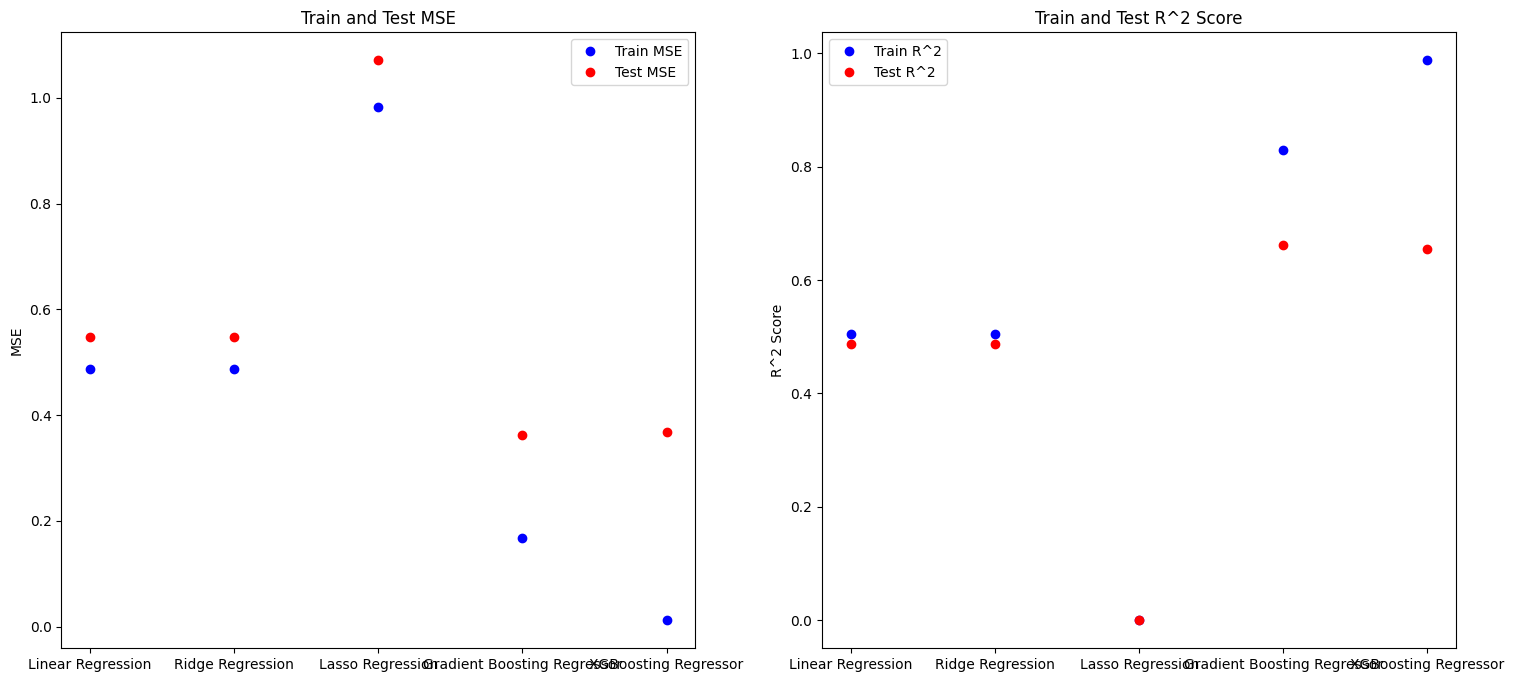

In [24]:
gross_data = data.drop(['Budget', 'profit'], axis=1)
X_gross = gross_data.drop('Gross (worldwide)', axis=1)
y_gross = gross_data['Gross (worldwide)']
X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X_gross, y_gross, test_size=0.2, random_state=888)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'XGBoosting Regressor': XGBRegressor()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_gross, y_train_gross)
    y_train_pred = model.predict(X_train_gross)
    y_test_pred = model.predict(X_test_gross)
    
    train_mse = mean_squared_error(y_train_gross, y_train_pred)
    test_mse = mean_squared_error(y_test_gross, y_test_pred)
    train_r2 = r2_score(y_train_gross, y_train_pred)
    test_r2 = r2_score(y_test_gross, y_test_pred)
    
    results[model_name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R^2': train_r2,
        'Test R^2': test_r2
    }


for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Train MSE: {metrics['Train MSE']:.4f}, Test MSE: {metrics['Test MSE']:.4f}")
    print(f"  Train R^2: {metrics['Train R^2']:.4f}, Test R^2: {metrics['Test R^2']:.4f}")


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train MSE'], 'bo', label='Train MSE' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test MSE'], 'ro', label='Test MSE' if model_name == 'Linear Regression' else "")
plt.title('Train and Test MSE')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train R^2'], 'bo', label='Train R^2' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test R^2'], 'ro', label='Test R^2' if model_name == 'Linear Regression' else "")
plt.title('Train and Test R^2 Score')
plt.ylabel('R^2 Score')
plt.legend()

plt.show()


# Classification :

In [2]:
data = pd.read_csv('preprocessed_original.csv')
data = data.select_dtypes(include=[float, int])
data.columns

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)', 'profit', 'North America', 'Oceania',
       'Europe', 'Africa', 'Asia', 'South America', 'Adventure', 'Horror',
       'Mystery', 'Crime', 'Drama', 'Fantasy', 'Animation', 'Thriller',
       'Action', 'Romance', 'Biography', 'Comedy', 'Family', 'Sci-Fi',
       'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'],
      dtype='object')

In [7]:
X = data.drop(['Africa', 'North America', 'Europe', 'Oceania', 'Asia', 'South America'], axis=1)
y = data[['Africa', 'North America', 'Europe', 'Oceania', 'Asia', 'South America']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000004), loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=2, validation_split=0.2, 
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])


y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.values.argmax(axis=-1)


print(classification_report(y_test_classes, y_pred_classes, zero_division=0))

Epoch 1/200


c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


176/176 - 3s - loss: 2.6482 - accuracy: 0.0799 - val_loss: 2.5688 - val_accuracy: 0.0724 - 3s/epoch - 15ms/step
Epoch 2/200
176/176 - 2s - loss: 2.6051 - accuracy: 0.1456 - val_loss: 2.5278 - val_accuracy: 0.1506 - 2s/epoch - 9ms/step
Epoch 3/200
176/176 - 2s - loss: 2.5640 - accuracy: 0.2031 - val_loss: 2.4865 - val_accuracy: 0.2770 - 2s/epoch - 9ms/step
Epoch 4/200
176/176 - 2s - loss: 2.5214 - accuracy: 0.2947 - val_loss: 2.4446 - val_accuracy: 0.4375 - 2s/epoch - 9ms/step
Epoch 5/200
176/176 - 2s - loss: 2.4756 - accuracy: 0.3970 - val_loss: 2.4012 - val_accuracy: 0.6080 - 2s/epoch - 10ms/step
Epoch 6/200
176/176 - 2s - loss: 2.4255 - accuracy: 0.5096 - val_loss: 2.3553 - val_accuracy: 0.7486 - 2s/epoch - 10ms/step
Epoch 7/200
176/176 - 2s - loss: 2.3888 - accuracy: 0.5930 - val_loss: 2.3077 - val_accuracy: 0.8651 - 2s/epoch - 10ms/step
Epoch 8/200
176/176 - 2s - loss: 2.3385 - accuracy: 0.6839 - val_loss: 2.2574 - val_accuracy: 0.9176 - 2s/epoch - 9ms/step
Epoch 9/200
176/176 - 2s

c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimiza

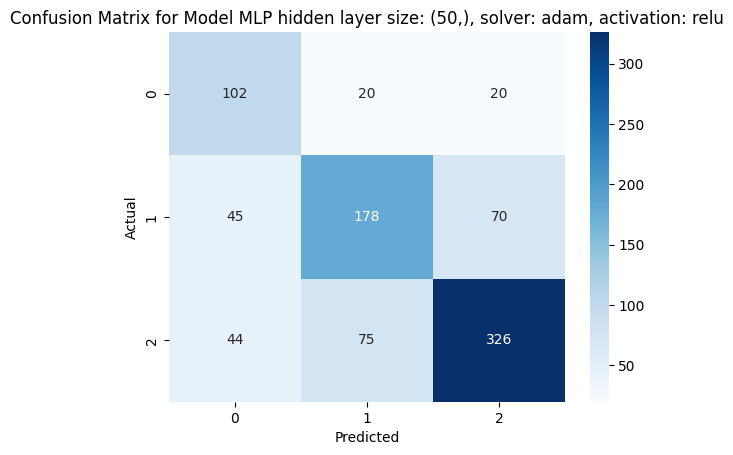

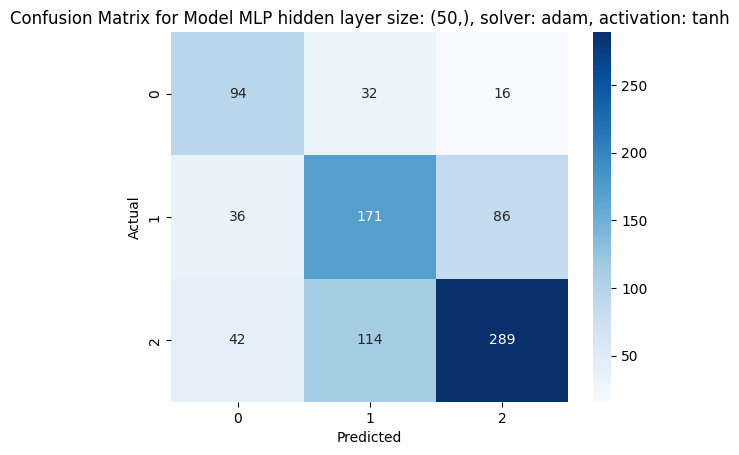

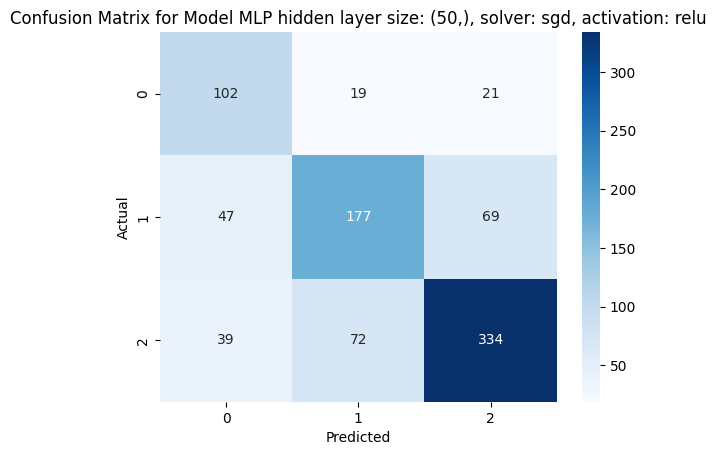

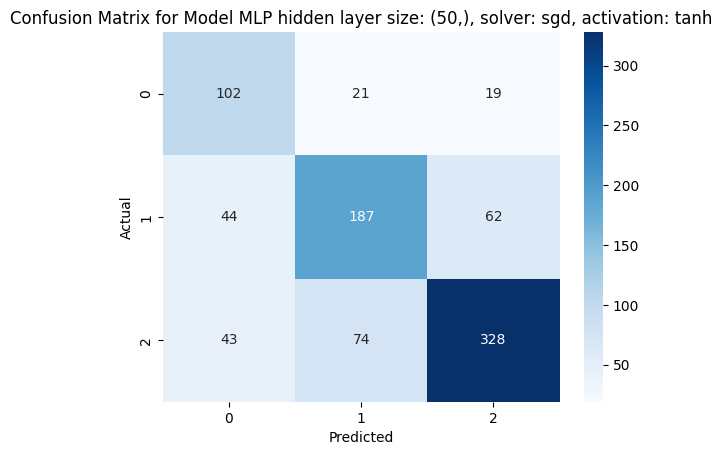

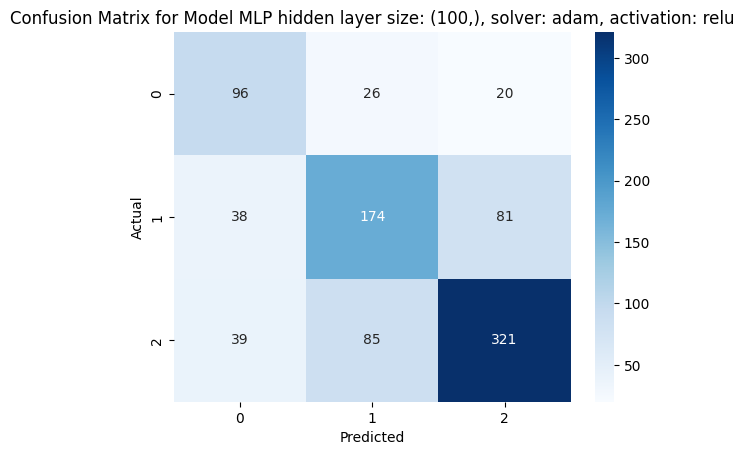

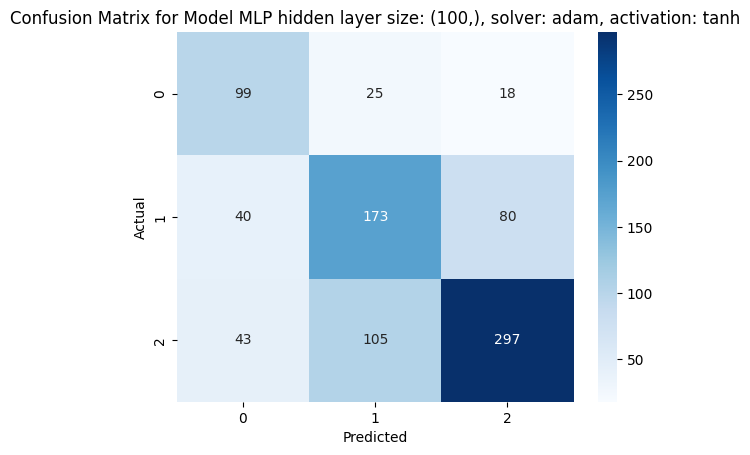

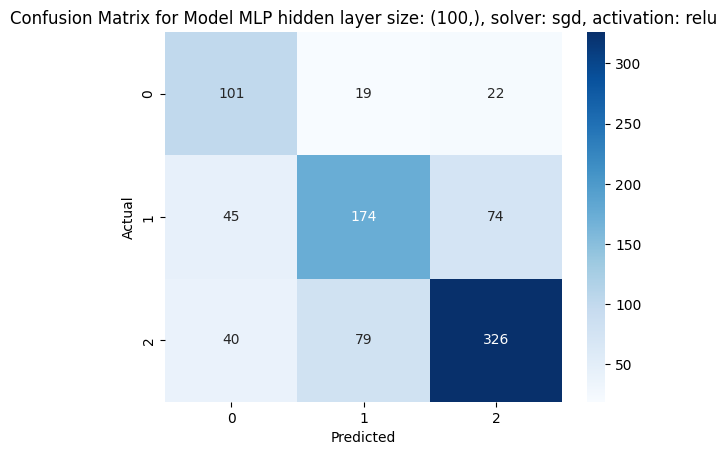

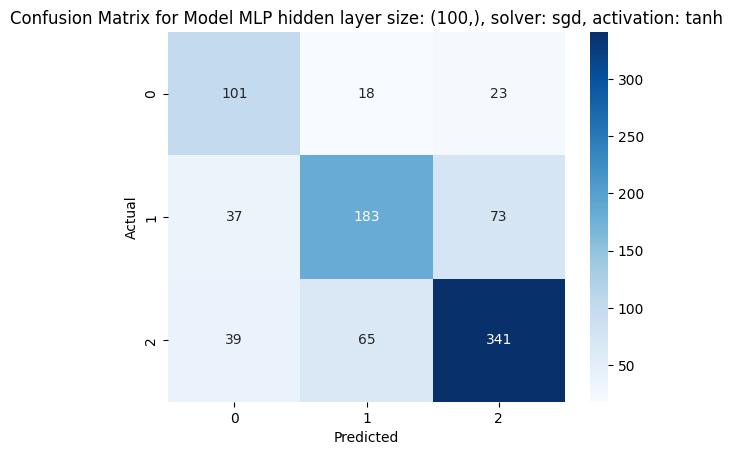

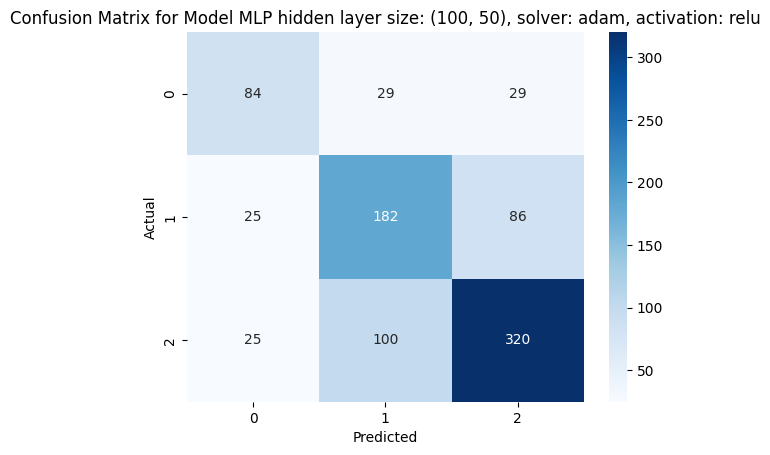

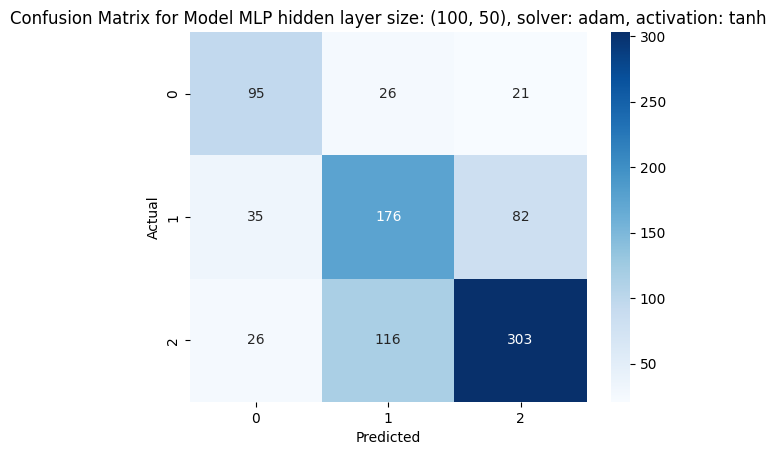

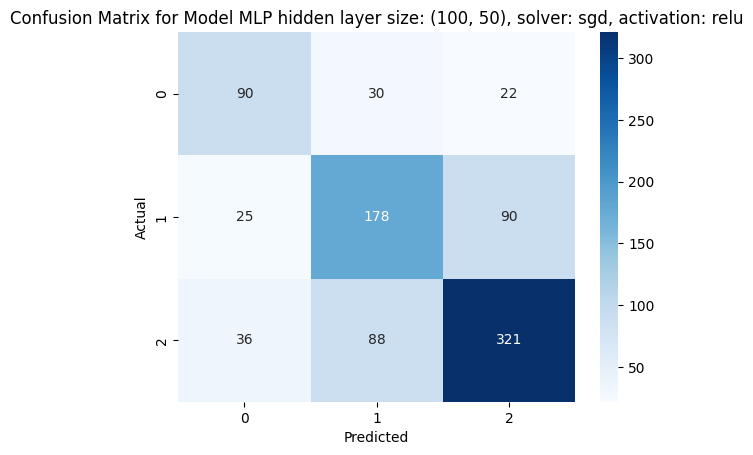

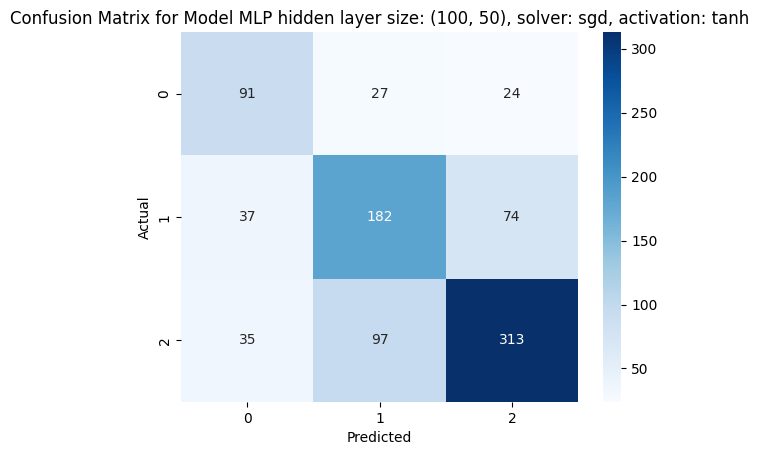

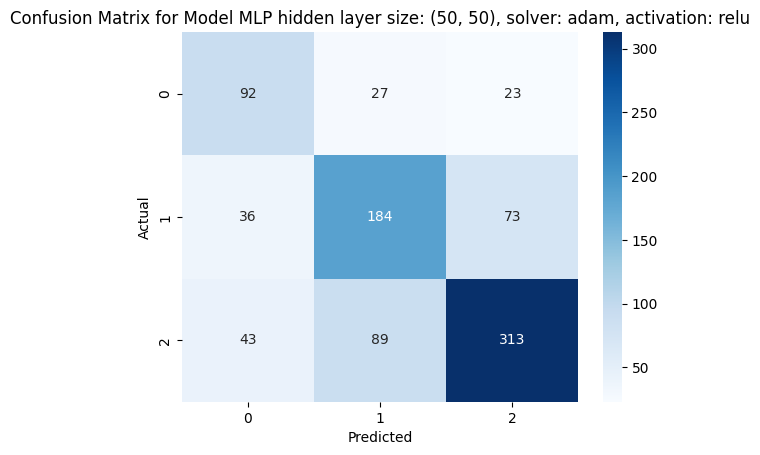

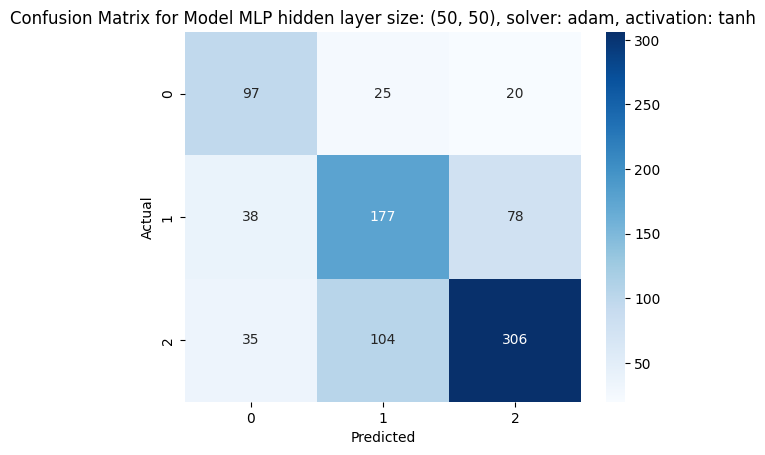

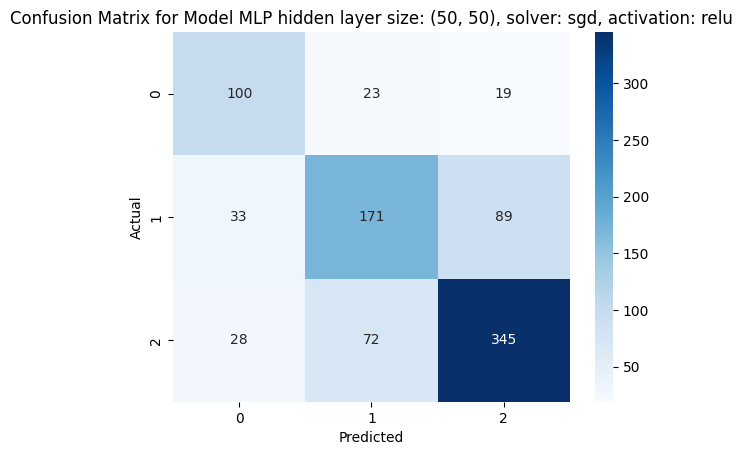

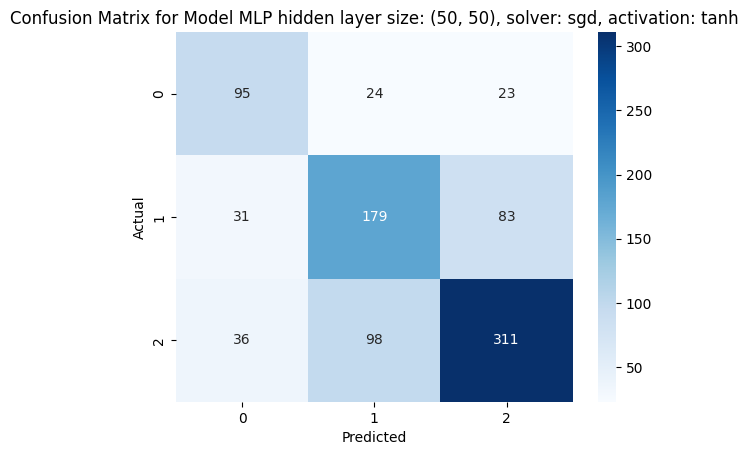

Model:  MLP hidden layer size: (50,), solver: adam, activation: relu
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       142
           1       0.64      0.62      0.63       293
           2       0.78      0.76      0.77       445

   micro avg       0.74      0.69      0.71       880
   macro avg       0.75      0.66      0.70       880
weighted avg       0.74      0.69      0.71       880
 samples avg       0.67      0.69      0.68       880

Model:  MLP hidden layer size: (50,), solver: adam, activation: tanh
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       142
           1       0.53      0.60      0.56       293
           2       0.71      0.70      0.71       445

   micro avg       0.64      0.64      0.64       880
   macro avg       0.65      0.62      0.63       880
weighted avg       0.65      0.64      0.64       880
 samples avg       0.61      0.64      0.62    

In [5]:
features = data.drop([ 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'], axis=1)
target = data[[ 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)

MLPevaluator = Evaluator({}, X_train, y_train, X_test, y_test)

for hidden_layer_size in [(50, ), (100, ), (100, 50), (50, 50)]:
    for solver in ['adam', 'sgd']:
        for activation in ['relu', 'tanh']:
            MLPevaluator.train_new_models({f'MLP hidden layer size: {hidden_layer_size}, solver: {solver}, activation: {activation}':MLPClassifier(hidden_layer_sizes=hidden_layer_size, solver=solver, activation=activation,
                                                                                                        max_iter=4000,random_state=888)})
_ = MLPevaluator.calculate_confusion_matrix()
MLPevaluator.evaluate_models()


## Random forest : 

### Random Forest Classifier 

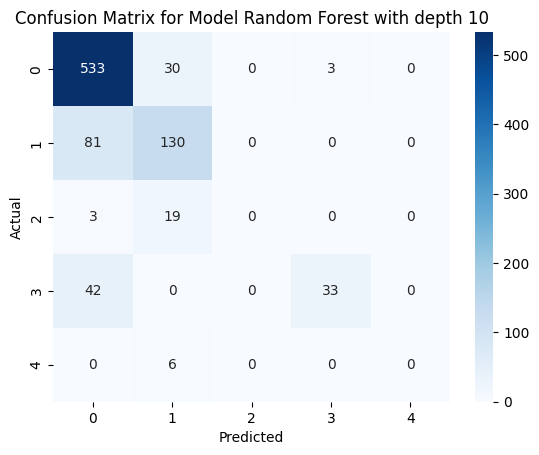

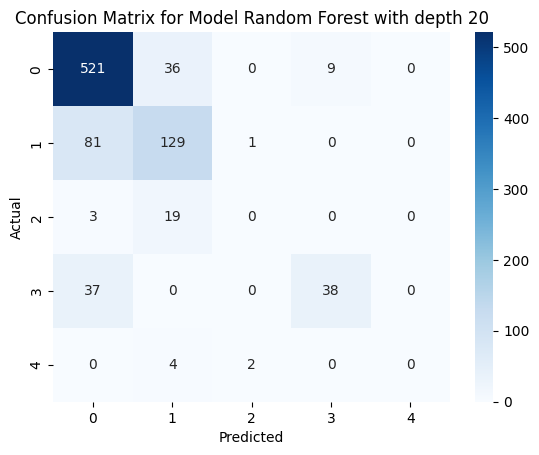

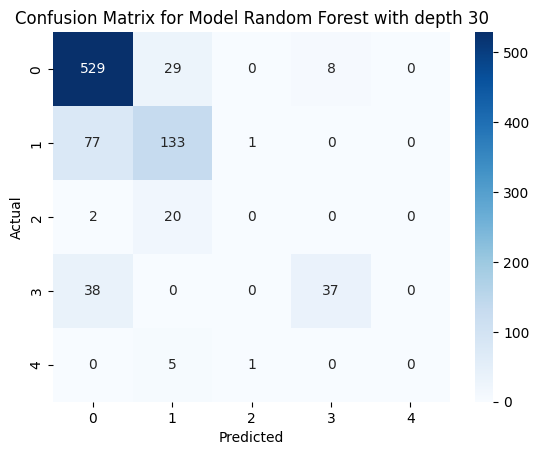

Model:  Random Forest with depth 10
               precision    recall  f1-score   support

Above Average       0.81      0.94      0.87       566
      Average       0.70      0.62      0.66       211
Below Average       0.00      0.00      0.00        22
         High       0.92      0.44      0.59        75
          Low       0.00      0.00      0.00         6

     accuracy                           0.79       880
    macro avg       0.49      0.40      0.42       880
 weighted avg       0.77      0.79      0.77       880

Model:  Random Forest with depth 20
               precision    recall  f1-score   support

Above Average       0.81      0.92      0.86       566
      Average       0.69      0.61      0.65       211
Below Average       0.00      0.00      0.00        22
         High       0.81      0.51      0.62        75
          Low       0.00      0.00      0.00         6

     accuracy                           0.78       880
    macro avg       0.46      0.41      0.4

In [ ]:
RFevaluator = Evaluator({}, X_train, y_train, X_test, y_test)


for depth in [10, 20, 30]:
    RFevaluator.train_new_models({f'Random Forest with depth {depth}': RandomForestClassifier(max_depth=depth)})
  
_ = RFevaluator.calculate_confusion_matrix()
RFevaluator.evaluate_models()


### MLP Classifier using hyper tuning and balancing 

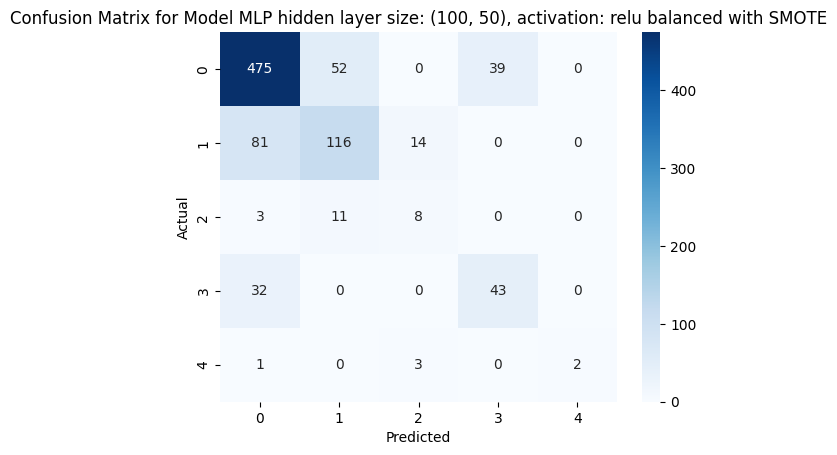

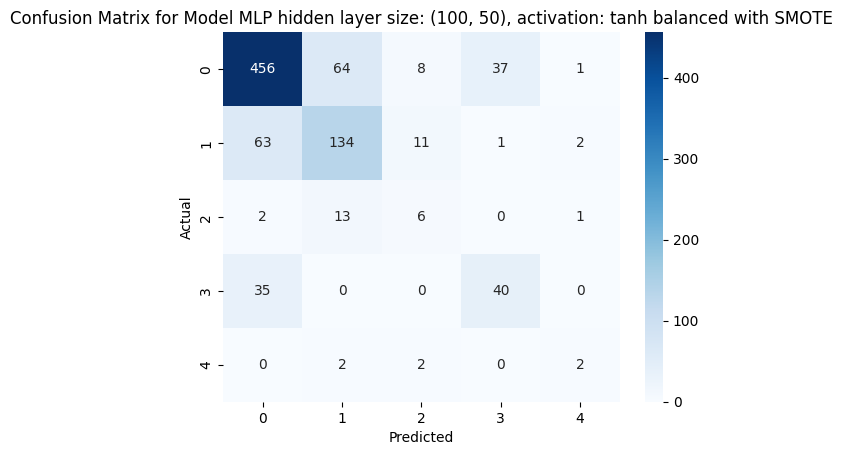

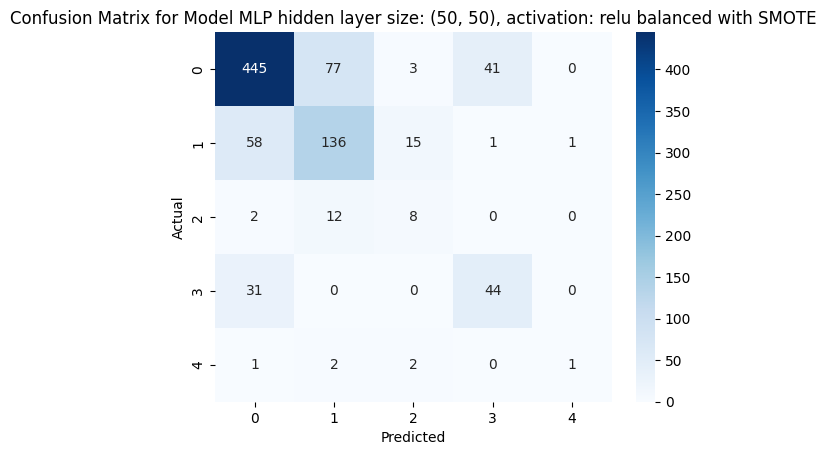

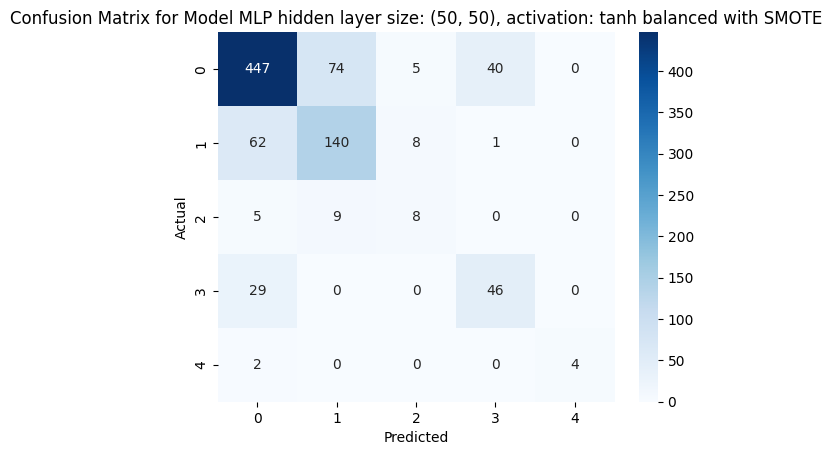

Model:  MLP hidden layer size: (100, 50), activation: relu balanced with SMOTE
               precision    recall  f1-score   support

Above Average       0.80      0.84      0.82       566
      Average       0.65      0.55      0.59       211
Below Average       0.32      0.36      0.34        22
         High       0.52      0.57      0.55        75
          Low       1.00      0.33      0.50         6

     accuracy                           0.73       880
    macro avg       0.66      0.53      0.56       880
 weighted avg       0.73      0.73      0.73       880

Model:  MLP hidden layer size: (100, 50), activation: tanh balanced with SMOTE
               precision    recall  f1-score   support

Above Average       0.82      0.81      0.81       566
      Average       0.63      0.64      0.63       211
Below Average       0.22      0.27      0.24        22
         High       0.51      0.53      0.52        75
          Low       0.33      0.33      0.33         6

     accurac

In [ ]:
y_train_np = y_train.to_numpy()

smote = SMOTE(random_state=888)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_np)

MLPevaluator = Evaluator({}, X_train_balanced, y_train_balanced, X_test, y_test)

for hidden_layer_size in [(100, 50), (50, 50)]:
    for solver in ['adam']:
        for activation in ['relu', 'tanh']:
            MLPevaluator.train_new_models({f'MLP hidden layer size: {hidden_layer_size}, activation: {activation} balanced with SMOTE':MLPClassifier(hidden_layer_sizes=hidden_layer_size, solver=solver, activation=activation,
                                                                                                        max_iter=1000,random_state=888)})
_ = MLPevaluator.calculate_confusion_matrix()
MLPevaluator.evaluate_models()


### Predincting Raiting Class using MLP classifier and smote

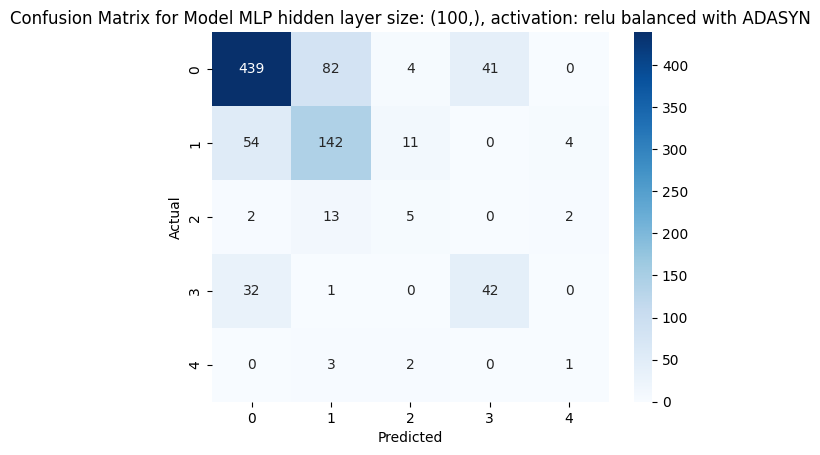

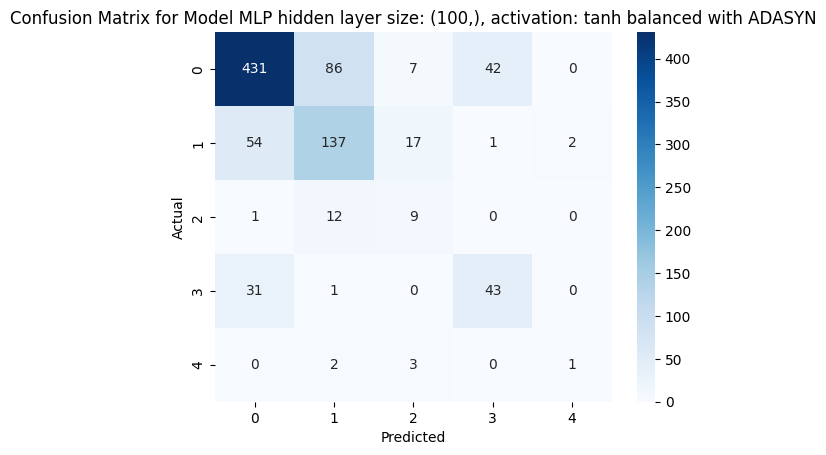

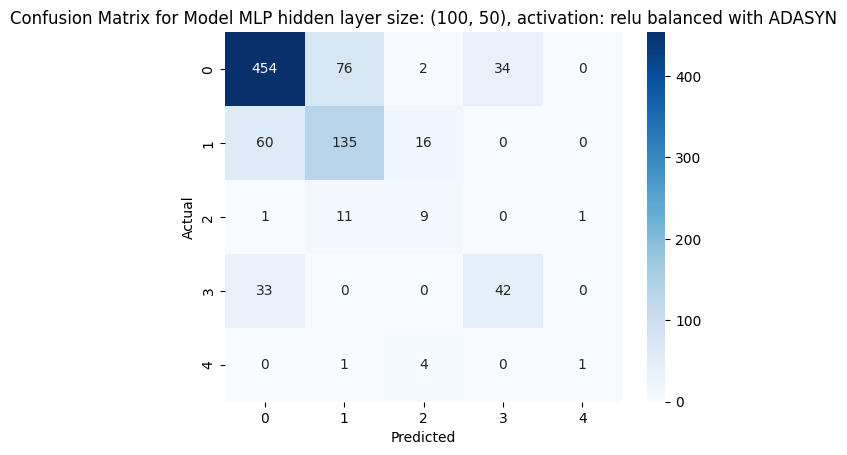

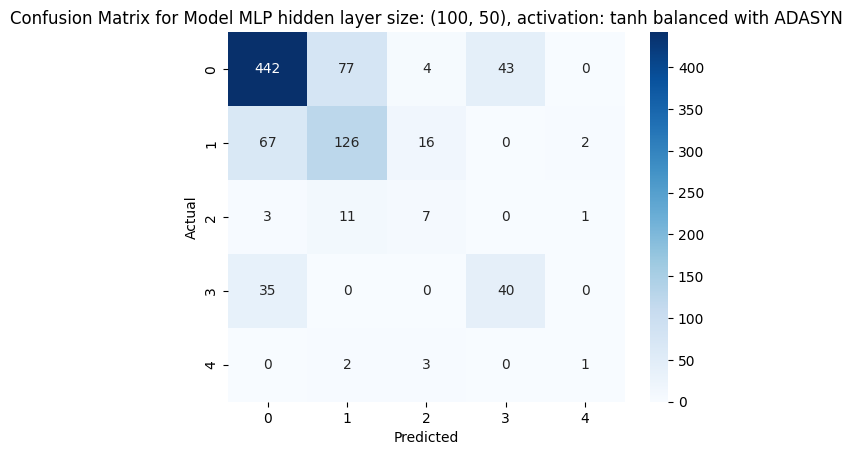

Model:  MLP hidden layer size: (100,), activation: relu balanced with ADASYN
               precision    recall  f1-score   support

Above Average       0.83      0.78      0.80       566
      Average       0.59      0.67      0.63       211
Below Average       0.23      0.23      0.23        22
         High       0.51      0.56      0.53        75
          Low       0.14      0.17      0.15         6

     accuracy                           0.71       880
    macro avg       0.46      0.48      0.47       880
 weighted avg       0.73      0.71      0.72       880

Model:  MLP hidden layer size: (100,), activation: tanh balanced with ADASYN
               precision    recall  f1-score   support

Above Average       0.83      0.76      0.80       566
      Average       0.58      0.65      0.61       211
Below Average       0.25      0.41      0.31        22
         High       0.50      0.57      0.53        75
          Low       0.33      0.17      0.22         6

     accuracy   

In [ ]:
data = pd.read_csv('preprocessed_original.csv')

data['Rating_Class'] = pd.cut(data['Rating'], bins=5, labels=['Low', 'Below Average', 'Average', 'Above Average', 'High'])
features = data.drop(['Rating', 'Rating_Class'], axis=1)
target = data['Rating_Class']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)


adasyn = ADASYN(random_state=888)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

MLPevaluator = Evaluator({}, X_train_balanced, y_train_balanced, X_test, y_test)

for hidden_layer_size in [(100, ), (100, 50)]:
    for solver in ['adam']:
        for activation in ['relu', 'tanh']:
            MLPevaluator.train_new_models({f'MLP hidden layer size: {hidden_layer_size}, activation: {activation} balanced with ADASYN':MLPClassifier(hidden_layer_sizes=hidden_layer_size, solver=solver, activation=activation,
                                                                                                        max_iter=1000,random_state=888)})
_ = MLPevaluator.calculate_confusion_matrix()
MLPevaluator.evaluate_models()

PART 7

We initially started crawling the IMDB webpage using Selenium (to automate the process) and BeautifulSoap (to extract the required info from each movie) and we managed to extract the data of more than 6000 movies with about 14 features. Our next step was to have a glance at the dataset and see if we could extract anything useful. For example, as the time goes on, the rating of the movies with 'Mystery' genre is falling, indicating that Mysterious movies are not appealing, but rather appalling.

Finally, we tried to train a few models in order to predict three features: Rating, Age Restriction, and Gross using numurous models like XGBoost, MLP, Random Forest, and even Deep Neural Networks and tried to apply different dataset balancing techniques like SMOTE and ADASYN. The result are already up there. 